In [151]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import csv
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sn
import statistics
from scipy import stats
import numpy.linalg

data.csv includes lastest edition FIFA 2019 players attributes like Age, Nationality, Overall, Club,              
Wage, Preferred_Foot, Position, Height, Weight, ShortPassing, FKAccuracy, LongPassing, BallControl, Acceleration, SprintSpeed, Agility, Reactions, Balance, ShotPower, Jumping, Stamina, Strength, LongShots, Positioning, Penalties.  

Данные включают в себя последние издания FIFA 2019 игроков атрибуты, такие как Возраст, Национальность, Общий, Клуб, Заработная плата, Предпочтительная нога, Положение, Рост, Вес, Шортпассинг, Точность FK,Long Passing, Контроль мяча, Ускорение, Скорость спринта, Ловкость,Реакции, баланс, сила удара, прыжки, выносливость, сила,Длинные выстрелы, Позиционирование, Пенальти

In [152]:
master_data=pd.read_csv('data.csv')
master_data.head()
master_data.drop(columns = ['Unnamed: 0','Name','ID','WorkRate','BodyType','RealFace','LoanedFrom','Value','InternationalReputation','Joined','WeakFoot','GKDiving', 'GKHandling','GKKicking', 'GKPositioning','Aggression','Vision','Vision','Special', 'SkillMoves','Volleys', 'Dribbling', 'Curve','Interceptions', 'HeadingAccuracy','Crossing', 'Potential','Finishing', 'GKReflexes', 'ReleaseClause','ContractValidUntil','JerseyNumber','Flag','ClubLogo','LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB','Photo','Composure', 'Marking', 'StandingTackle', 'SlidingTackle'], inplace=True)
master_data.columns.str.strip()
master_data.rename(columns = {'PreferredFoot':'Preferred_Foot'                              
                             }, inplace = True)
master_data.fillna(master_data.mean(), inplace=True)
# 

Подготовка данных, убираем NaN значения - заменяем на среднее значение, переводим единицы измерения к русским и обрабатываем категориальные признаки

In [153]:
master_data['Wage'] = master_data.Wage.str.replace('€','')
master_data['Wage'] = master_data.Wage.str.replace('K','000')
master_data['Wage'] = master_data.Wage.astype('int64')
master_data['Weight'] = master_data.Weight.str.replace('lbs','').astype('float64')
master_data['Height'] = master_data.Height.str.replace('\'','.').astype('float64')
master_data.fillna(0, inplace=True)
master_data['Preferred_Foot'] = master_data.Preferred_Foot.astype('category')
master_data['Nationality'] = master_data.Nationality.astype('category')
master_data['Club'] = master_data.Club.astype('category')
master_data['Position'] = master_data.Position.astype('category')
master_data['Weight'] = master_data.Weight*0.454
master_data['Height'] = master_data.Height*30

In [154]:
master_data.head().T

,0,1,2,3,4
Age,31,33,26,27,27
Nationality,Argentina,Portugal,Brazil,Spain,Belgium
Overall,94,94,92,91,91
Club,FCBarcelona,Juventus,ParisSaint-Germain,ManchesterUnited,ManchesterCity
Wage,565000,405000,290000,260000,355000
Preferred_Foot,Left,Right,Right,Right,Right
Position,RF,ST,LW,GK,RCM
Height,171,186,177,192,153.3
Weight,72.186,83.082,68.1,76.272,69.916
ShortPassing,90,81,84,50,92


Для данного массива проведем статистический анализ каждой переменной, вычислив ее выборочные числовые характеристики: среднее, дисперсию, моду, медиану, эксцесс, асимметрию, коэффициент вариации, размах.

In [155]:
cols = ['Mean', 'Mode', 'Median', 'Variance', 'Skew', 'Kurtosis', 'Range', 'Std', 'k variation']
temp= []
dt_stat = pd.DataFrame(columns=cols)
pre_dt = 0
for name, values in master_data.iteritems():
    if (master_data[name].dtype.name != 'category'):
#         temp.append(name)
        temp.append(statistics.mean(master_data[name]))
        temp.append(statistics.mode(master_data[name]))
        temp.append(statistics.median(master_data[name]))
        temp.append(statistics.variance(master_data[name]))
        temp.append(stats.skew(master_data[name]))
        temp.append(stats.kurtosis(master_data[name]))
        temp.append(np.max(master_data[name])-np.min(master_data[name]))
        temp.append(np.std(master_data[name]))
        temp.append(np.std(master_data[name])/statistics.mean(master_data[name])*100)  
        dt_stat.loc[name] = temp
        temp=[]
        pre_dt = pre_dt+1
print(dt_stat)
        

                     Mean     Mode   Median      Variance      Skew  \
Age             25.122206    21.00    25.00  2.180836e+01  0.391732   
Overall         66.238699    66.00    66.00  4.773331e+01  0.067179   
Wage          9731.312133  1000.00  3000.00  4.839688e+08  7.905368   
Height         173.462498   180.00   177.00  2.598840e+02 -3.541539   
Weight          75.155864    74.91    74.91  6.491681e+01 -1.936397   
ShortPassing    58.686712    64.00    62.00  2.155055e+02 -1.101678   
FKAccuracy      42.863153    42.00    41.00  3.047017e+02  0.102244   
LongPassing     52.711933    62.00    56.00  2.343242e+02 -0.596378   
BallControl     58.369459    65.00    63.00  2.777084e+02 -1.269433   
Acceleration    64.614076    69.00    67.00  2.222511e+02 -0.816311   
SprintSpeed     64.726967    68.00    67.00  2.140553e+02 -0.829612   
Agility         63.503607    68.00    66.00  2.174614e+02 -0.600158   
Reactions       61.836610    65.00    62.00  8.097442e+01 -0.114268   
Balanc

Визуализация разброса каждого фактора

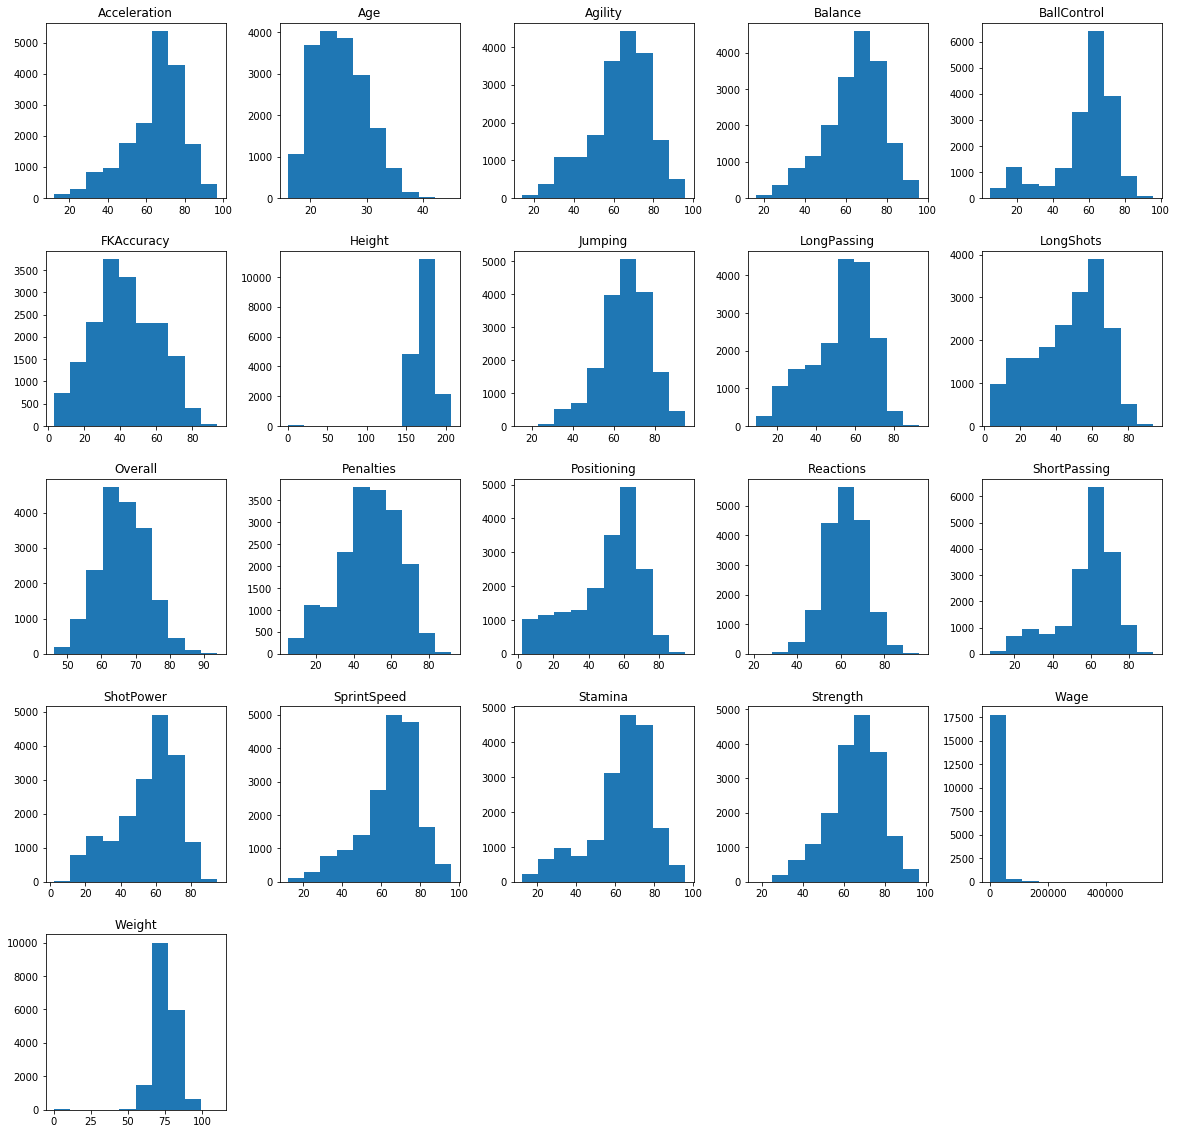

In [156]:
histohrams = master_data.hist(grid=False, figsize=(20, 20))

Построим корреляционную матрицу для вычисления тесноты связей между зависимой переменной и каждым фактором

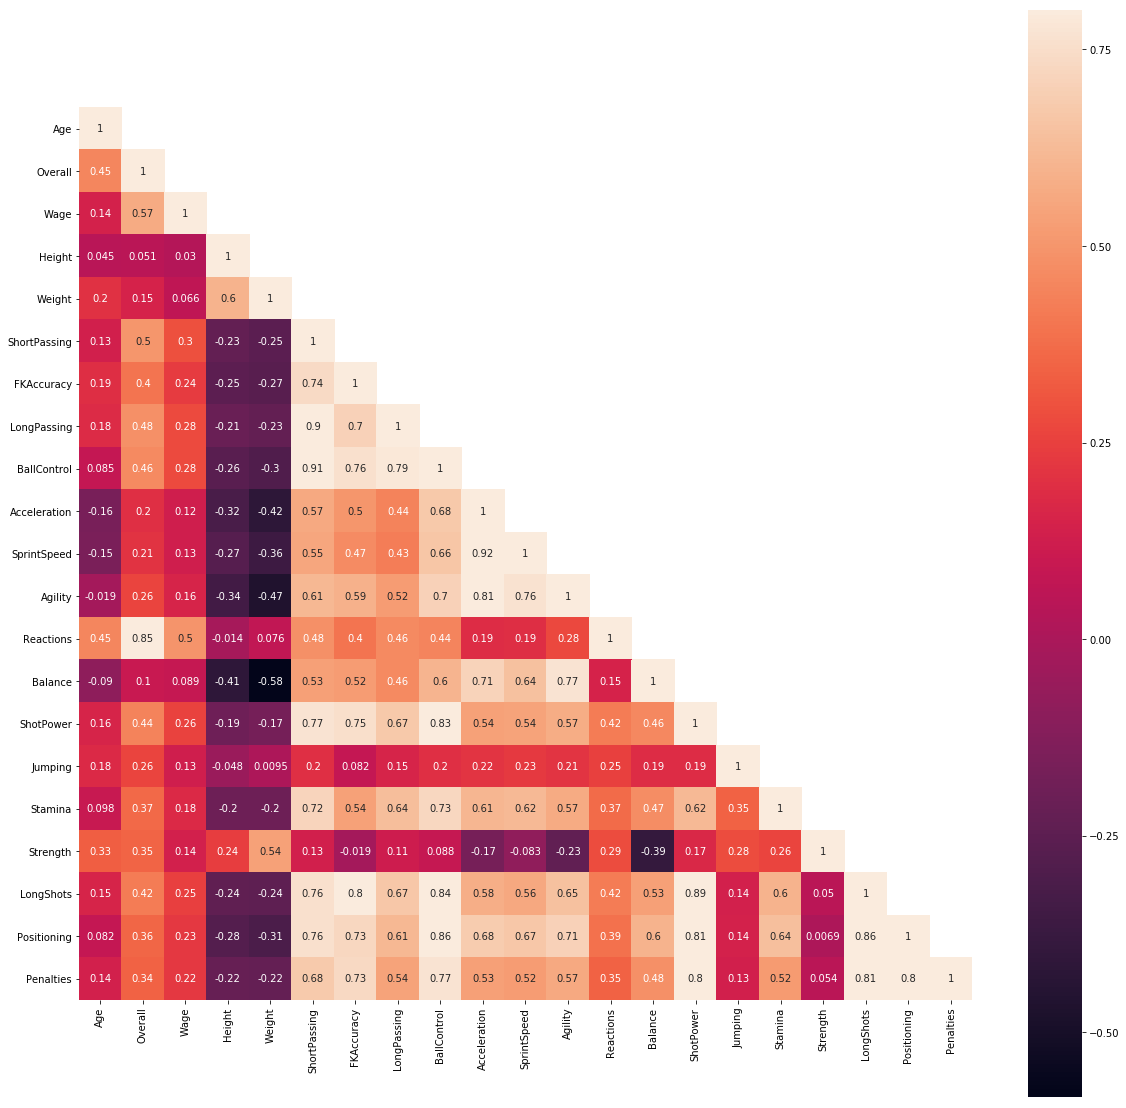

In [157]:
corr = master_data.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(20,20)
sn.heatmap(corr, mask=mask, vmax=.8, square=True, annot = True)

Построим уравнение множественной линейной регрессии, включив в модель все имеющиеся факторы.

Набор обучающих данных будет использоваться для обучения нашей линейной модели. Тестовый набор выбирается случайным образом данных будет использоваться для проверки модели. Все данные из тестового набора данных будут новыми для модели, и мы сможем проверить, насколько точны прогнозы модели.

In [158]:
X = master_data.drop(['Overall',
                     'Nationality',
                      'Club',
                      'Preferred_Foot',
                      'Position'], axis=1)
Y = master_data['Overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

Коэффициенты регрессии

In [159]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, Y_train)
cdf = pd.DataFrame(lin_reg.coef_,X.columns, columns=['Coefficients'])
print(cdf)
print("Independent term in the model "+ str(lin_reg.intercept_))

              Coefficients
Age               0.164388
Wage              0.000058
Height            0.013182
Weight            0.048456
ShortPassing      0.037104
FKAccuracy        0.003342
LongPassing       0.016070
BallControl       0.053203
Acceleration      0.026309
SprintSpeed       0.018089
Agility           0.033184
Reactions         0.472103
Balance          -0.035418
ShotPower         0.018569
Jumping           0.013852
Stamina          -0.032327
Strength          0.028149
LongShots         0.012049
Positioning      -0.058753
Penalties        -0.019629
Independent term in the model 19.025631675705625


Сравниваем предсказанное с тестом

In [160]:
Y_pred = lin_reg.predict(X_test)
# print('Prediction:', len(Y_pred))
# средне квадратическая ошибка
mse = mean_squared_error(Y_test, Y_pred)
print('mean_squared_error : ',mse)

mean_squared_error :  9.998080272283616


In [161]:
#R^2 (coefficient of determination) regression score function.
r2 = r2_score(Y_test, Y_pred)
print('r2 score: ',r2)
r2_adj = 1-((1-r2*r2)*(Y_pred.size-1)/(Y_pred.size-1-len(X_test.columns)))
print('r2_adj:', r2_adj)

r2 score:  0.7905559045000142
r2_adj: 0.6239458059672656


In [162]:
alfa = 0.05
n = Y_pred.size-1-len(X_test.columns)
t = stats.t(n)
tcr = t.ppf(1-alfa/2)
F = (r2/(1-r2))*((Y_pred.size-len(X_test.columns)-1)/len(X_test.columns))
print("F :", F )
print ("t-stat_cr ", tcr)
print ("queue_mean", np.mean(Y_pred))
print ("queue_di", tcr*np.std(Y_pred)/np.sqrt(Y_pred.size))

F : 1370.5368405765093
t-stat_cr  1.9602907071984967
queue_mean 66.1844416722046
queue_di 0.14024742388787187


МНК

In [163]:
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
# print(est2.summary())

In [164]:
abs(est2.tvalues) > tcr

const            True
Age              True
Wage             True
Height           True
Weight           True
ShortPassing     True
FKAccuracy      False
LongPassing      True
BallControl      True
Acceleration     True
SprintSpeed      True
Agility          True
Reactions        True
Balance          True
ShotPower        True
Jumping          True
Stamina          True
Strength         True
LongShots        True
Positioning      True
Penalties        True
dtype: bool

Незначимы: FKAccuracy

In [165]:
Xm = sm.add_constant(X_train)
temp = Xm.values
# print(np.matrix(Xm))
print("det(X.T*X)",np.linalg.det((np.matrix(Xm.values).T*np.matrix(Xm.values))))

det(X.T*X) 1.346155844551809e+128


In [166]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const           357.464747
Age               1.571563
Wage              1.364425
Height            1.621167
Weight            2.530392
ShortPassing     12.111727
FKAccuracy        3.683723
LongPassing       6.104672
BallControl      12.183901
Acceleration      8.925698
SprintSpeed       7.314270
Agility           4.533378
Reactions         2.071111
Balance           3.533021
ShotPower         6.186029
Jumping           1.351296
Stamina           3.075625
Strength          2.652534
LongShots         7.743191
Positioning       6.595803
Penalties         3.877805
dtype: float64

Получается так. Часто используют границу 5 или 10, если показатель VIF больше данного значения - есть линейная зависимость от остальных переменных

Если VIF (Variance Inflation Factor) возле каждой независимой переменной меньше 10 — значит, эффекта мультиколлинеарности не наблюдается и регрессионная модель приемлема для дальнейшей интерпретации. Чем выше показатель VIF, тем более связаны между собой переменные

Пересторим модель без учета факторов ShortPassing и BallControl

In [167]:
X = master_data.drop(['Overall',
                     'Nationality',
                      'Club',
                      'Preferred_Foot',
                      'Position',
                      'ShortPassing',
                      'BallControl',
                     ], axis=1)
Y = master_data['Overall']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
# print(est2.summary())
X3=[]
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const           395.471923
Age               1.561676
Wage              1.369105
Height            1.536333
Weight            2.496043
FKAccuracy        3.781809
LongPassing       2.819772
Acceleration      8.740777
SprintSpeed       7.261586
Agility           4.474661
Reactions         2.063763
Balance           3.541178
ShotPower         5.975141
Jumping           1.354915
Stamina           2.946826
Strength          2.599375
LongShots         7.826267
Positioning       5.637439
Penalties         3.721995
dtype: float64

методом включения факторов в модель на основе прироста скорректированного коэффициента детерминации построим уравнение множественной регрессии

In [168]:
for i in X_train.columns:
    col = [i]
    XX = X_train[col]
    X2 = sm.add_constant(XX)
    est = sm.OLS(Y_train, X2)
    est2 = est.fit()
    print('factor :',i,'r2_adj:',est2.rsquared_adj)

factor : Age r2_adj: 0.212064677836852
factor : Wage r2_adj: 0.3237748309173927
factor : Height r2_adj: 0.002140132527335248
factor : Weight r2_adj: 0.02417968642296675
factor : FKAccuracy r2_adj: 0.16015398770829836
factor : LongPassing r2_adj: 0.24179998439907124
factor : Acceleration r2_adj: 0.039563120990720346
factor : SprintSpeed r2_adj: 0.04611288488638332
factor : Agility r2_adj: 0.06886825107570005
factor : Reactions r2_adj: 0.7217663817374884
factor : Balance r2_adj: 0.010066519957867004
factor : ShotPower r2_adj: 0.20066161437712116
factor : Jumping r2_adj: 0.06559375428890202
factor : Stamina r2_adj: 0.1349911415567402
factor : Strength r2_adj: 0.12462188623300119
factor : LongShots r2_adj: 0.18021156070092703
factor : Positioning r2_adj: 0.12851393894705065
factor : Penalties r2_adj: 0.11756028771246851


Reactions r2_adj: 0.722806811955127 - max r2_adj

In [169]:
col=['Reactions']
for i in X_train.columns:
    if i!='Reactions':
        col.append(i)
        XX = X_train[col]
        X2 = sm.add_constant(XX)
        est = sm.OLS(Y_train, X2)
        est2 = est.fit()
        print('factors', col,'r2_adj:',est2.rsquared_adj)
        col=['Reactions']

factors ['Reactions', 'Age'] r2_adj: 0.7281369598739817
factors ['Reactions', 'Wage'] r2_adj: 0.7503123287158852
factors ['Reactions', 'Height'] r2_adj: 0.7252577715343294
factors ['Reactions', 'Weight'] r2_adj: 0.7287386397341291
factors ['Reactions', 'FKAccuracy'] r2_adj: 0.726532927749518
factors ['Reactions', 'LongPassing'] r2_adj: 0.7338740804024158
factors ['Reactions', 'Acceleration'] r2_adj: 0.723284311847264
factors ['Reactions', 'SprintSpeed'] r2_adj: 0.7239584661279334
factors ['Reactions', 'Agility'] r2_adj: 0.722856346589844
factors ['Reactions', 'Balance'] r2_adj: 0.7222175432218343
factors ['Reactions', 'ShotPower'] r2_adj: 0.7315629550334026
factors ['Reactions', 'Jumping'] r2_adj: 0.7240598276664356
factors ['Reactions', 'Stamina'] r2_adj: 0.7250605389657327
factors ['Reactions', 'Strength'] r2_adj: 0.7341780699403162
factors ['Reactions', 'LongShots'] r2_adj: 0.7271920162136305
factors ['Reactions', 'Positioning'] r2_adj: 0.7228672330320778
factors ['Reactions', 'Pena

factors ['Reactions', 'Wage'] r2_adj: 0.7532802394031949 - max 

In [170]:
col=['Reactions','Wage']
for i in X_train.columns:
    if ((i!='Reactions')or(i!='Wage')):
        col.append(i)
        XX = X_train[col]
        X2 = sm.add_constant(XX)
        est = sm.OLS(Y_train, X2)
        est2 = est.fit()
        print('factors', col,'r2_adj:',est2.rsquared_adj)
        col=['Reactions','Wage']

factors ['Reactions', 'Wage', 'Age'] r2_adj: 0.760087781590334
factors ['Reactions', 'Wage', 'Wage'] r2_adj: 0.750312328715885
factors ['Reactions', 'Wage', 'Height'] r2_adj: 0.7530321517382109
factors ['Reactions', 'Wage', 'Weight'] r2_adj: 0.7564556551180512
factors ['Reactions', 'Wage', 'FKAccuracy'] r2_adj: 0.7540676210893911
factors ['Reactions', 'Wage', 'LongPassing'] r2_adj: 0.7604244888651374
factors ['Reactions', 'Wage', 'Acceleration'] r2_adj: 0.7513624548460213
factors ['Reactions', 'Wage', 'SprintSpeed'] r2_adj: 0.751896815031175
factors ['Reactions', 'Wage', 'Agility'] r2_adj: 0.7511449673525833
factors ['Reactions', 'Wage', 'Reactions'] r2_adj: 0.7503123287158852
factors ['Reactions', 'Wage', 'Balance'] r2_adj: 0.7509175977142407
factors ['Reactions', 'Wage', 'ShotPower'] r2_adj: 0.7580619998635507
factors ['Reactions', 'Wage', 'Jumping'] r2_adj: 0.7525083604412224
factors ['Reactions', 'Wage', 'Stamina'] r2_adj: 0.7537593456040419
factors ['Reactions', 'Wage', 'Strength'

factors ['Reactions', 'Wage', 'Strength'] r2_adj: 0.7667135825917197 - max

In [171]:
col=['Reactions','Wage','Strength']
for i in X_train.columns:
    if ((i!='Reactions')or(i!='Wage')or(i!='Strength')):
        col.append(i)
        XX = X_train[col]
        X2 = sm.add_constant(XX)
        est = sm.OLS(Y_train, X2)
        est2 = est.fit()
        print('factors', col,'r2_adj:',est2.rsquared_adj)
        col=['Reactions','Wage','Strength']

factors ['Reactions', 'Wage', 'Strength', 'Age'] r2_adj: 0.7683721312526102
factors ['Reactions', 'Wage', 'Strength', 'Wage'] r2_adj: 0.762955948933838
factors ['Reactions', 'Wage', 'Strength', 'Height'] r2_adj: 0.763444184420196
factors ['Reactions', 'Wage', 'Strength', 'Weight'] r2_adj: 0.7632915550294521
factors ['Reactions', 'Wage', 'Strength', 'FKAccuracy'] r2_adj: 0.769185002804311
factors ['Reactions', 'Wage', 'Strength', 'LongPassing'] r2_adj: 0.7735146381499395
factors ['Reactions', 'Wage', 'Strength', 'Acceleration'] r2_adj: 0.7667079570912216
factors ['Reactions', 'Wage', 'Strength', 'SprintSpeed'] r2_adj: 0.7663475309406342
factors ['Reactions', 'Wage', 'Strength', 'Agility'] r2_adj: 0.7682596982965653
factors ['Reactions', 'Wage', 'Strength', 'Reactions'] r2_adj: 0.7629559489338379
factors ['Reactions', 'Wage', 'Strength', 'Balance'] r2_adj: 0.7638135305319826
factors ['Reactions', 'Wage', 'Strength', 'ShotPower'] r2_adj: 0.7695750693988906
factors ['Reactions', 'Wage', 'S

In [172]:
col=['Reactions','Wage','Strength']
XX = X_train[col]
X2 = sm.add_constant(XX)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.summary())
print(est2.conf_int())
# print(est2)

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                 1.172e+04
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        00:31:14   Log-Likelihood:                -28787.
No. Observations:               10924   AIC:                         5.758e+04
Df Residuals:                   10920   BIC:                         5.761e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.0678      0.273     98.995      0.0

In [173]:
X3 = add_constant(X2)
pd.Series([vif(X3.values, i) 
               for i in range(X3.shape[1])], 
              index=X3.columns)

const        71.684658
Reactions     1.422365
Wage          1.328459
Strength      1.091890
dtype: float64

In [174]:
np.linalg.cond(est2.model.exog)

207284.40384005208

In [175]:
np.abs(est2.params/np.std(Y_train)*np.std(X_train[col])).sort_values(ascending = False)

Reactions    0.718233
Wage         0.195581
Strength     0.117587
const             NaN
dtype: float64

In [176]:
np.abs(est2.params/np.mean(Y_train)*np.mean(X_train[col])).sort_values(ascending = False)

Reactions    0.518018
Strength     0.064440
Wage         0.008928
const             NaN
dtype: float64

In [177]:
print(len(Y_train))
print(len(X2))
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X2, Y_train)
print(np.size(lin_reg.predict(X2)))

10924
10924
10924


In [178]:
np.mean(lin_reg.predict(X2) - Y_train)

7.857988640349478e-15

Так как значение получилось близко к нулю, то считается, что модель не содержит систематической ошибки и адекватна по критерию нулевого среднего

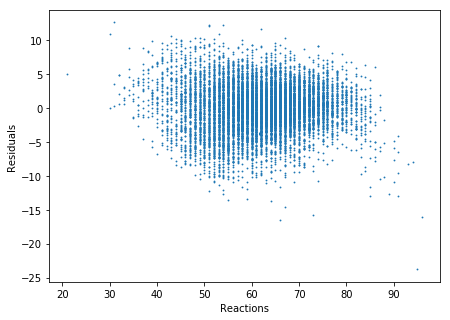

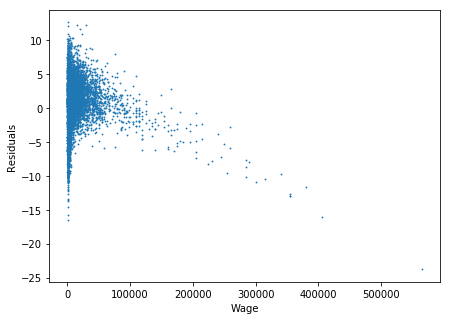

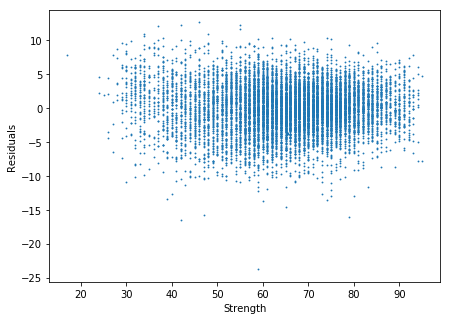

In [179]:
for i, j in enumerate(col):
    plt.figure(figsize=(7,5))
    plt.scatter(X_train[j], est2.resid, s=0.7)
    plt.xlabel(j)
    plt.ylabel('Residuals')

plt.show()


In [180]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(est2.resid, est2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 944.8029037567533),
 ('p-value', 1.6932684503174416e-204),
 ('f-value', 344.6251774072339),
 ('f p-value', 7.725431922844992e-214)]

f_pvalue = 0, поэтому H0(гомоскедастичность) отклоняется.

In [181]:
durbin_watson(est2.resid)

1.9808910414249485

~2, следовательно, нет автокорреляциии